<a href="https://colab.research.google.com/github/WTL-522/lpf2_rcnn/blob/main/LPF2_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 新增：安装和导入必要的库
# 原因：需要访问Google Drive中的文件
!pip install -U -q PyDrive

import os
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 导入Keras库（使用TensorFlow 2.x版本）
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("环境设置完成")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 57.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
环境设置完成


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
尝试访问文件: /content/drive/MyDrive/Colab Notebooks/Data_set_v2/Data_set_v2/Sec_III_A/LPF2.dat
文件存在，大小: 20000004 字节
尝试方式1: np.fromfile读取...
方式1读取的数据形状: (10000002,)
方式1读取的前10个数据: [   152 -27008   -188   -144   -145   -163   -124    -85   -264   -275]
处理后数据形状: (10000000,)
处理后前10个数据: [-24 -18 -19 -21 -16 -11 -33 -35 -11 -12]
均值: -20.93, 标准差: 6.03


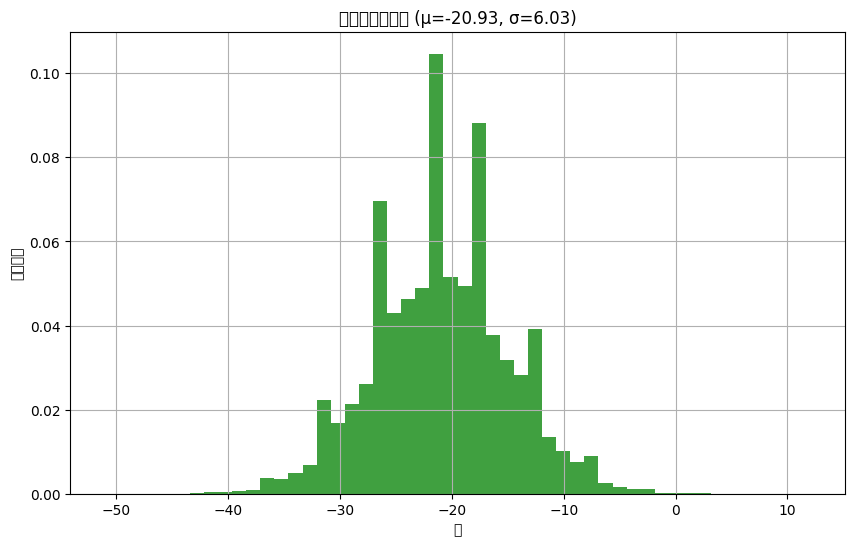

In [8]:
# 重新设计数据加载部分 - 修复版本
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt

# 挂载Google Drive
drive.mount('/content/drive')

# 设置文件路径 - 请确认你的文件路径
file_path = '/content/drive/MyDrive/Colab Notebooks/Data_set_v2/Data_set_v2/Sec_III_A/LPF2.dat'  # 请根据你的实际路径修改

print(f"尝试访问文件: {file_path}")

# 检查文件是否存在和文件大小
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path)
    print(f"文件存在，大小: {file_size} 字节")

    if file_size == 0:
        print("错误：文件为空")
    else:
        # 尝试不同的读取方式
        try:
            # 方式1：使用np.fromfile读取
            print("尝试方式1: np.fromfile读取...")
            data = np.fromfile(file_path, dtype='>i2')  # 大端16位整数
            print(f"方式1读取的数据形状: {data.shape}")
            print(f"方式1读取的前10个数据: {data[:10]}")

            if len(data) > 2:
                data = data[2:]   # 排除前两个头部值
                data = data >> 3  # 右移3位
                print(f"处理后数据形状: {data.shape}")
                print(f"处理后前10个数据: {data[:10]}")

                # 存储数据
                alldata = data

                # 显示统计信息
                mu, sigma = np.mean(data), np.std(data)
                print(f"均值: {mu:.2f}, 标准差: {sigma:.2f}")

                # 绘制直方图
                plt.figure(figsize=(10, 6))
                n, bins, patches = plt.hist(data, 50, density=True, facecolor='green', alpha=0.75)
                plt.xlabel('值')
                plt.ylabel('概率密度')
                plt.title(f'数据分布直方图 (μ={mu:.2f}, σ={sigma:.2f})')
                plt.grid(True)
                plt.show()

            else:
                print("错误：数据长度不足")

        except Exception as e:
            print(f"方式1失败: {e}")

            try:
                # 方式2：尝试以二进制模式读取
                print("尝试方式2: 二进制读取...")
                with open(file_path, 'rb') as f:
                    binary_data = f.read()
                print(f"二进制数据长度: {len(binary_data)} 字节")

                # 尝试解析为16位整数
                data = np.frombuffer(binary_data, dtype='>i2')
                print(f"方式2读取的数据形状: {data.shape}")

                if len(data) > 2:
                    data = data[2:]   # 排除前两个头部值
                    data = data >> 3  # 右移3位
                    print(f"处理后数据形状: {data.shape}")
                    alldata = data
                else:
                    print("错误：二进制数据解析后长度不足")

            except Exception as e2:
                print(f"方式2也失败: {e2}")
                print("请检查文件格式是否正确")
else:
    print("错误：文件不存在")
    print("请检查文件路径是否正确")
    print("常见的正确路径格式:")
    print("- /content/drive/MyDrive/你的文件夹/LPF2.dat")
    print("- /content/drive/MyDrive/LPF2.dat")

In [9]:
# 继续数据分割 - 基于成功加载的数据
print("开始数据分割...")

total_size = len(alldata)
print(f"总数据量: {total_size}")

# 使用原始论文中的分割比例
train_size = 5000000  # 500万训练数据
test_size = 1000000   # 每个测试集100万数据

text = alldata[:train_size]
test1 = alldata[train_size:train_size+test_size]
test2 = alldata[train_size+test_size:train_size+2*test_size]
test3 = alldata[train_size+2*test_size:train_size+3*test_size]
test4 = alldata[train_size+3*test_size:train_size+4*test_size]
test5 = alldata[train_size+4*test_size:train_size+5*test_size]

# 转换为列表和字符串
text = list(text)
test1 = list(test1)
test2 = list(test2)
test3 = list(test3)
test4 = list(test4)
test5 = list(test5)

text = list(map(str, text))
test1 = list(map(str, test1))
test2 = list(map(str, test2))
test3 = list(map(str, test3))
test4 = list(map(str, test4))
test5 = list(map(str, test5))

print(f"训练数据: {len(text)}, 测试集1: {len(test1)}, 测试集5: {len(test5)}")
print(f"训练数据示例: {text[:5]}")

开始数据分割...
总数据量: 10000000
训练数据: 5000000, 测试集1: 1000000, 测试集5: 1000000
训练数据示例: ['-24', '-18', '-19', '-21', '-16']


In [10]:
# 创建字典
print("创建字典...")

# 使用所有数据创建字典以确保覆盖所有可能的字符
all_text_data = text + test1 + test2 + test3 + test4 + test5
chars = sorted(list(set(all_text_data)))

print(f"字符数量: {len(chars)}")
print(f"前10个字符: {chars[:10]}")

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# 释放内存
del all_text_data
print("字典创建完成")

创建字典...
字符数量: 63
前10个字符: ['-1', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18']
字典创建完成


In [11]:
# 创建训练样本 - 优化内存版本
# 由于Colab内存限制，我们使用较小的序列长度
maxlen = 20  # 从100减少到20以适应Colab内存
step = 3

print(f"创建训练样本，序列长度: {maxlen}, 步长: {step}")

sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: (i + maxlen)])
    next_chars.append(text[(i + maxlen)])
print(f'序列数量: {len(sentences)}')

print('开始向量化...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('向量化完成!')
print(f"X形状: {X.shape}, y形状: {y.shape}")
print(f"内存使用估算: X - {X.nbytes/1024/1024:.2f}MB, y - {y.nbytes/1024/1024:.2f}MB")

创建训练样本，序列长度: 20, 步长: 3
序列数量: 1666660
开始向量化...
向量化完成!
X形状: (1666660, 20, 63), y形状: (1666660, 63)
内存使用估算: X - 2002.71MB, y - 100.14MB


In [12]:
# 构建模型 - 适应Colab资源版本
print('构建模型...')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, MaxPooling1D
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu',
                input_shape=(maxlen, len(chars))))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
monitoring = ModelCheckpoint('weights_QRNG_colab.h5', monitor='val_loss',
                           verbose=1, save_best_only=True)

构建模型...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 63)             │         4,095 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 63)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,439 (208.75 KB)

 Trainable params: 53,439 (208.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
# 训练模型
print("开始训练...")

# 由于数据量较大，我们使用较小的批量大小和较少的轮数
history = model.fit(X, y, epochs=15, batch_size=64, validation_split=0.2,
                   verbose=1, callbacks=[early_stopping, monitoring])

print("加载最佳权重...")
model.load_weights('weights_QRNG_colab.h5')

开始训练...
Epoch 1/15
20834/20834 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0643 - loss: 3.2302
Epoch 1: val_loss improved from inf to 3.21179, saving model to weights_QRNG_colab.h5


20834/20834 ━━━━━━━━━━━━━━━━━━━━ 146s 7ms/step - accuracy: 0.0643 - loss: 3.2302 - val_accuracy: 0.0660 - val_loss: 3.2118
Epoch 2/15
20831/20834 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0661 - loss: 3.2127
Epoch 2: val_loss did not improve from 3.21179
20834/20834 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - accuracy: 0.0661 - loss: 3.2127 - val_accuracy: 0.0659 - val_loss: 3.2125
Epoch 3/15
20834/20834 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0658 - loss: 3.2144
Epoch 3: val_loss did not improve from 3.21179
20834/20834 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - accuracy: 0.0658 - loss: 3.2144 - val_accuracy: 0.0672 - val_loss: 3.2153
Epoch 4/15
20833/20834 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0659 - loss: 3.2183
Epoch 4: val_loss did not improve from 3.21179
20834/20834 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - accuracy: 0.0659 - loss: 3.2183 - val_accuracy: 0.0674 - val_loss: 3.2170
Epoch 4: early stopping
加载最佳权重...


In [14]:
# 测试模型 - 分批处理版本
tests = [test1, test2, test3, test4, test5]
test_names = ['测试集1', '测试集2', '测试集3', '测试集4', '测试集5']

# 为了节省内存，我们只测试前两个测试集
tests = tests[:2]
test_names = test_names[:2]

for test, name in zip(tests, test_names):
    print(f"\n{name}测试中...")

    # 创建测试样本
    test_sentences = []
    test_next_chars = []
    for i in range(0, len(test) - maxlen, step):
        test_sentences.append(test[i: (i + maxlen)])
        test_next_chars.append(test[(i + maxlen)])
    print(f'测试序列数量: {len(test_sentences)}')

    # 分批向量化和预测
    batch_size = 1000
    total_batches = (len(test_sentences) + batch_size - 1) // batch_size
    n_true = 0
    total_tested = 0

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(test_sentences))

        batch_sentences = test_sentences[start_idx:end_idx]
        batch_next_chars = test_next_chars[start_idx:end_idx]

        # 向量化当前批次
        Xt_batch = np.zeros((len(batch_sentences), maxlen, len(chars)), dtype=bool)
        yt_batch = np.zeros((len(batch_sentences), len(chars)), dtype=bool)

        for i, sentence in enumerate(batch_sentences):
            for t, char in enumerate(sentence):
                Xt_batch[i, t, char_indices[char]] = 1
            yt_batch[i, char_indices[batch_next_chars[i]]] = 1

        # 预测当前批次
        preds = model.predict(Xt_batch, verbose=0)
        pred_indices = np.argmax(preds, axis=1)
        true_indices = np.argmax(yt_batch, axis=1)

        batch_correct = np.sum(pred_indices == true_indices)
        n_true += batch_correct
        total_tested += len(batch_sentences)

        if (batch_idx + 1) % 10 == 0:
            current_accuracy = n_true / total_tested * 100
            print(f"批次 {batch_idx+1}/{total_batches}, 当前准确率: {current_accuracy:.2f}%")

    accuracy = n_true / total_tested * 100
    print(f"{name}结果: {n_true}/{total_tested} 正确, 准确率: {accuracy:.5f}%")


测试集1测试中...
测试序列数量: 333327
批次 10/334, 当前准确率: 6.83%
批次 20/334, 当前准确率: 6.67%
批次 30/334, 当前准确率: 6.57%
批次 40/334, 当前准确率: 6.59%
批次 50/334, 当前准确率: 6.49%
批次 60/334, 当前准确率: 6.49%
批次 70/334, 当前准确率: 6.47%
批次 80/334, 当前准确率: 6.48%
批次 90/334, 当前准确率: 6.58%
批次 100/334, 当前准确率: 6.60%
批次 110/334, 当前准确率: 6.60%
批次 120/334, 当前准确率: 6.62%
批次 130/334, 当前准确率: 6.62%
批次 140/334, 当前准确率: 6.60%
批次 150/334, 当前准确率: 6.61%
批次 160/334, 当前准确率: 6.61%
批次 170/334, 当前准确率: 6.62%
批次 180/334, 当前准确率: 6.61%
批次 190/334, 当前准确率: 6.61%
批次 200/334, 当前准确率: 6.62%
批次 210/334, 当前准确率: 6.62%
批次 220/334, 当前准确率: 6.62%
批次 230/334, 当前准确率: 6.62%
批次 240/334, 当前准确率: 6.62%
批次 250/334, 当前准确率: 6.62%
批次 260/334, 当前准确率: 6.62%
批次 270/334, 当前准确率: 6.62%
批次 280/334, 当前准确率: 6.61%
批次 290/334, 当前准确率: 6.61%
批次 300/334, 当前准确率: 6.60%
批次 310/334, 当前准确率: 6.60%
批次 320/334, 当前准确率: 6.59%
批次 330/334, 当前准确率: 6.59%
测试集1结果: 21955/333327 正确, 准确率: 6.58663%

测试集2测试中...
测试序列数量: 333327
批次 10/334, 当前准确率: 6.22%
批次 20/334, 当前准确率: 6.56%
批次 30/334, 当前准确率: 6.64%
批次 40/334, 当前准确率: 6


保存结果到Google Drive...
Mounted at /content/drive
已保存: weights_QRNG_colab.h5


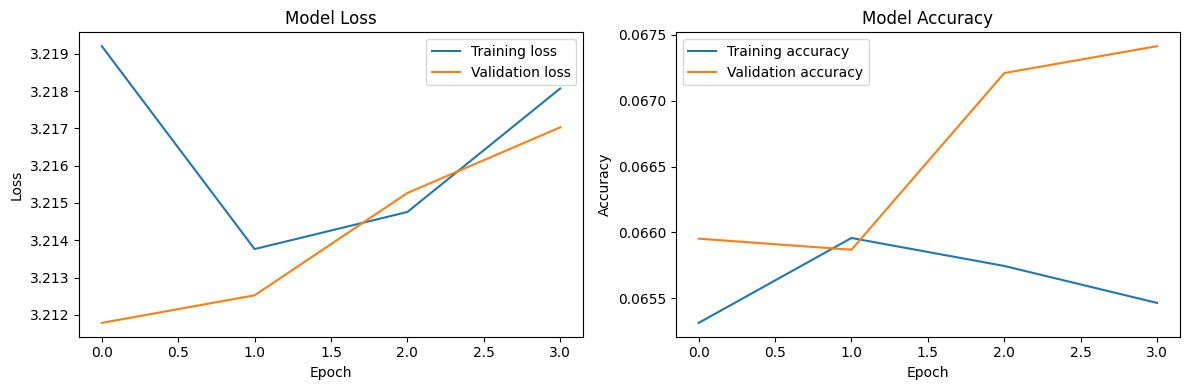

所有结果已保存到: /content/drive/MyDrive/QRNG_Results
🎉 程序完成!


In [16]:
# 保存结果到Google Drive
print("\n保存结果到Google Drive...")

import shutil

# 确保Google Drive已挂载
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 创建保存结果的文件夹
results_dir = '/content/drive/MyDrive/QRNG_Results'
os.makedirs(results_dir, exist_ok=True)

# 复制模型文件到Google Drive
model_files = ['weights_QRNG_colab.h5']
for file in model_files:
    if os.path.exists(file):
        shutil.copy(file, os.path.join(results_dir, file))
        print(f"已保存: {file}")

# 绘制训练历史
# 绘制训练历史
plt.figure(figsize=(12, 4))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'training_history.png'),
            dpi=150, bbox_inches='tight')
plt.show()
print(f"所有结果已保存到: {results_dir}")
print("🎉 程序完成!")